In [56]:
import re
import os
import vrplib
import random
import matplotlib.pyplot as plt
import requests


# Read all instances
def read_all_instances(root_folder, ending='.tsp'):
    instances = []

    def extract_k_and_n_numbers(file_name):
        # Extract 'k' and 'n' numbers from the file name
        k_match = re.search(r'k(\d+)', file_name)
        n_match = re.search(r'n(\d+)', file_name)

        # If both matches are successful, return a tuple of (k, n)
        k = int(k_match.group(1)) if k_match else float('inf')
        n = int(n_match.group(1)) if n_match else float('inf')
        return k, n

    # Sort the file names according to (k, n)
    file_names = sorted(
        [file_name for file_name in os.listdir(root_folder) if file_name.endswith(ending)],
        key=extract_k_and_n_numbers
    )

    for file_name in file_names:
        instance = vrplib.read_instance(os.path.join(root_folder, file_name))
        if instance:
            instances.append(instance)
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')

    return instances


# Define a function to visualize the solution
def plot_CVRP_solution(routes, node_coords):
    plt.figure(figsize=(10, 8))

    # Plot the nodes
    for i, (x, y) in enumerate(node_coords):
        plt.scatter(x, y, c='blue' if i == 0 else 'red')
        plt.text(x, y, f'{i}', fontsize=9, horizontalalignment='right')

    # Plot the routes
    colors = ['b', 'g', 'r', 'c','m', 'y', 'k']
    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c=colors[vehicle % len(colors)], label=f'Vehicle {vehicle + 1}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routing Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define a function to calculate the route distance
def calculate_route_distance(route, distance_matrix):
    distance = 0
    if route:
        distance += distance_matrix[0][route[0]]  # From the depot to the first node
        for i in range(1, len(route)):
            distance += distance_matrix[route[i - 1]][route[i]]
        distance += distance_matrix[route[-1]][0]  # From the last node back to the depot
    return distance


# Define a function to calculate the total distance of all routes (CVRP)
def total_distance(routes, distance_matrix):
    return sum(calculate_route_distance(route, distance_matrix) for route in routes)

def test_capacity_constraint_print(routes, demands, vehicle_capacity):
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)
        if total_demand > vehicle_capacity:
            print(f"Vehicle {vehicle + 1} exceeds capacity: {total_demand} > {vehicle_capacity}")
        else:
            print(f"Vehicle {vehicle + 1} is within capacity: {total_demand} <= {vehicle_capacity}")
            
# Generate an initial solution using the greedy method
def greedy_initial_solution(distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):
    routes = [[] for _ in range(num_vehicles)]
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes
    visited[0] = True  # Start from the depot

    for vehicle in range(num_vehicles):
        current_node = 0
        while True:
            next_node = None
            min_distance = float('inf')
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                    if distance_matrix[current_node][i] < min_distance:
                        min_distance = distance_matrix[current_node][i]
                        next_node = i
            if next_node is None:
                break
            routes[vehicle].append(next_node)
            current_load[vehicle] += demands[next_node]
            visited[next_node] = True
            current_node = next_node
    return routes


# Destroy the solution
def destroy_solution(routes, num_customers_to_remove):
    # Flatten the routes to get a list of all customers
    all_customers = [customer for route in routes for customer in route]

    # Ensure that the number of customers to be removed does not exceed the total number of customers
    num_customers_to_remove = min(num_customers_to_remove, len(all_customers))

    # Randomly select the customers to be removed
    removed_customers = random.sample(all_customers, num_customers_to_remove)

    new_routes = []
    for route in routes:
        new_route = [customer for customer in route if customer not in removed_customers]
        new_routes.append(new_route)

    return new_routes, removed_customers


# Repair the solution
'''
def repair_solution(routes, removed_customers, distance_matrix, demands, vehicle_capacity, num_vehicles):
    for customer in removed_customers:
        best_insertion = None
        best_cost_increase = float('inf')
        best_route_idx = None
        best_insert_position = None

        for route_idx, route in enumerate(routes):
            route_demand = sum(demands[node] for node in route)

            if route_demand + demands[customer] > vehicle_capacity:
                continue  # Skip this route

            for i in range(len(route) + 1):  # +1 allows the customer to be inserted at the end
                new_route = route[:i] + [customer] + route[i:]  # A - B -> Insert C. Cost(A-C-B) - Cost (A-B)
                cost_increase = calculate_route_distance(new_route, distance_matrix) - calculate_route_distance(route,
                                                                                                              distance_matrix)
                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_insertion = new_route
                    best_route_idx = route_idx
                    best_insert_position = i

        if best_insertion is not None:
            routes[best_route_idx] = best_insertion
        else:
            if len(routes) < num_vehicles:
                routes.append([customer])
            else:
                routes[0].append(customer)

    return routes
'''
def repair_solution(routes, removed_customers, distance_matrix, demands, vehicle_capacity, num_vehicles):
    for customer in removed_customers:
        best_insertion = None
        best_cost_increase = float('inf')
        best_route_idx = None
        best_insert_position = None

        for route_idx, route in enumerate(routes):
            route_demand = sum(demands[node] for node in route)

            if route_demand + demands[customer] > vehicle_capacity:
                continue # skip this route

            for i in range(len(route) + 1): # +1 you are allowed to insert the customer to the end
                new_route = route[:i] + [customer] + route[i:] # A - B -> Insert C. Cost(A-C-B) -  Cost (A-B)
                cost_increase = calculate_route_distance(new_route, distance_matrix) - calculate_route_distance(route, distance_matrix)
                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_insertion = new_route
                    best_route_idx = route_idx
                    best_insert_position = i
            
        if best_insertion is not None:
            routes[best_route_idx] = best_insertion
        else:
            if len(routes) < num_vehicles:
                routes.append([customer])
            else:
                routes[0].append(customer)

    return routes





# Generate a new solution according to the strategy
def generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):
    routes = [[] for _ in range(num_vehicles)]
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes
    visited[0] = True  # Start from the depot

    for vehicle in range(num_vehicles):
        current_node = 0
        while True:
            scores = []
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                    score = strategy[0] * demands[i] + strategy[1] * distance_matrix[current_node][i] + strategy[2]
                    scores.append((score, i))
                else:
                    scores.append((float('-inf'), i))
            best_score, best_node = max(scores)
            if best_score == float('-inf'):
                break
            routes[vehicle].append(best_node)
            current_load[vehicle] += demands[best_node]
            visited[best_node] = True
            current_node = best_node
    return routes

# 修改测试容量约束函数，返回是否全部满足
def test_capacity_constraint(routes, demands, vehicle_capacity):
    feasible = True
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)
        if total_demand > vehicle_capacity:
            feasible = False
            #print(f"Vehicle {vehicle + 1} exceeds capacity: {total_demand} > {vehicle_capacity}")  
    return feasible  


# 修改Large Neighborhood Search算法，加入可行性检查
def large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000,
                                   destruction_size=5):
    current_routes = greedy_initial_solution(distance_matrix, demands, num_vehicles, vehicle_capacity,
                                             len(distance_matrix))
    current_cost = total_distance(current_routes, distance_matrix)
    current_feasible = test_capacity_constraint(current_routes, demands, vehicle_capacity)  # 初始可行性
    
    best_routes = [route.copy() for route in current_routes]
    best_cost = current_cost
    best_feasible = current_feasible  # 记录最佳可行状态

    for iteration in range(num_iterations):
        # 破坏阶段
        partial_routes, removed_customers = destroy_solution(current_routes, destruction_size)
        
        # 修复阶段
        repaired_routes = repair_solution(partial_routes, removed_customers, distance_matrix, demands, vehicle_capacity,
                                          num_vehicles)
        
        repaired_feasible = test_capacity_constraint(repaired_routes, demands, vehicle_capacity)
        repaired_cost = total_distance(repaired_routes, distance_matrix) if repaired_feasible else float('inf')  # 不可行时设为无穷大
    
        if repaired_feasible and repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost
            current_feasible = repaired_feasible 
    
            if repaired_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = repaired_cost
                best_feasible = repaired_feasible

    return best_routes, best_cost, best_feasible  



def large_neighborhood_search_cvrp_LLM(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000,
                                       destruction_size=5):
    current_routes = generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity,
                                           len(distance_matrix))
    current_cost = total_distance(current_routes, distance_matrix)
    current_feasible = test_capacity_constraint(current_routes, demands, vehicle_capacity)
    
    best_routes = [route.copy() for route in current_routes]
    best_cost = current_cost
    best_feasible = current_feasible

    for iteration in range(num_iterations):
        # 破坏阶段
        partial_routes, removed_customers = destroy_solution(current_routes, destruction_size)
        
        # 修复阶段
        repaired_routes = repair_solution(partial_routes, removed_customers, distance_matrix, demands, vehicle_capacity,
                                          num_vehicles)

        repaired_feasible = test_capacity_constraint(repaired_routes, demands, vehicle_capacity)
        repaired_cost = total_distance(repaired_routes, distance_matrix) if repaired_feasible else float('inf')
        
        if repaired_feasible and repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost
            current_feasible = repaired_feasible
            
            if repaired_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = repaired_cost
                best_feasible = repaired_feasible

    return best_routes, best_cost, best_feasible 


def funsearch(distance_matrix, demands, num_vehicles, vehicle_capacity, data_detail_dict, num_iterations=10):

    api_key = "sk-9a43537e3d1b489886a9ef7fdfbede76"
    ds_model = DsModel(api_key)
    initial_routes, initial_cost, initial_feasible = large_neighborhood_search_cvrp(
        distance_matrix, demands, num_vehicles, vehicle_capacity
    )
    
    best_routes = initial_routes
    best_cost = initial_cost
    best_feasible = initial_feasible
    best_strategy = None
    all_strategy_results = []  # 记录（策略, 成本, 可行性）
    
    for _ in range(num_iterations):

        strategy = generate_strategy(ds_model, data_detail_dict, all_strategy_results)
        print(strategy)
 
        new_routes, new_cost, new_feasible = large_neighborhood_search_cvrp_LLM(
            strategy, distance_matrix, demands, num_vehicles, vehicle_capacity
        )
        print(new_cost,new_feasible)

        all_strategy_results.append((strategy, new_cost, new_feasible))
        
        if new_feasible:
            if new_cost < best_cost or not best_feasible:
                best_routes = new_routes
                best_cost = new_cost
                best_feasible = new_feasible
                best_strategy = strategy
        else:
            # 记录不可行解，但不更新最佳可行解
            pass

    return  initial_routes, initial_cost, initial_feasible,best_routes, best_cost, best_feasible, best_strategy, all_strategy_results  # 返回可行性状态




In [59]:
from typing import Collection
class DsModel:
    def __init__(self, api_key, model="deepseek-chat"):
        self.api_key = api_key
        self.system_prompt = """
        """
        BASE_URL = "https://api.deepseek.com"
        import openai
        self.client = openai.OpenAI(api_key=api_key, base_url=BASE_URL)
        self.model = model

    def call(self, prompt):
        content = f"{self.system_prompt} {prompt}"
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "user", "content": content}
                ],
                stream=False
            )
            print(response.choices[0].message.content)
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error calling Deepseek: {e}")
            return None


# 你提供的 LLM 类
class LLM:
    """Language model that predicts continuation of provided source code."""

    def __init__(self, samples_per_prompt: int, model: DsModel) -> None:
        # define the prompt pool
        self._model = model
        self._samples_per_prompt = samples_per_prompt

    def _draw_sample(self, prompt: str) -> str:
        """Returns a predicted continuation of `prompt`."""
        return self._model.call(prompt)

    def draw_samples(self, prompt: str) -> Collection[str]:
        """Returns multiple predicted continuations of `prompt`."""
        return [self._draw_sample(prompt) for _ in range(self._samples_per_prompt)]


import re  
import random  

def generate_strategy(ds_model,data_detail_dict, all_strategy_results):  
    prompt = f"""  
You are an expert in the CVRP (Capacitated Vehicle Routing Problem).  
The data you need to read this time is {data_detail_dict}. Please, according to the characteristics of this data, combined with the following code, return a weight value that conforms to the data characteristics.  

def generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):  
    routes = [[] for _ in range(num_vehicles)]  
    current_load = [0] * num_vehicles  
    visited = [False] * num_nodes  
    visited[0] = True  # Start from the depot  

    for vehicle in range(num_vehicles):  
        current_node = 0  
        while True:  
            scores = []  
            for i in range(1, num_nodes):  
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:  
                    score = strategy[0] * demands[i] + strategy[1] * distance_matrix[current_node][i] + strategy[2]  
                    scores.append((score, i))  
                else:  
                    scores.append((float('-inf'), i))  
            best_score, best_node = max(scores)  
            if best_score == float('-inf'):  
                break  
            routes[vehicle].append(best_node)  
            current_load[vehicle] += demands[best_node]  
            visited[best_node] = True  
            current_node = best_node  
    return routes  

The following are the previous weight settings, corresponding routes, and cost information:  
{all_strategy_results}  
Please boldly try new strategies based on the data results to find the global optimal solution. Strategies are not allowed to be repeated with historical data.  
Please give your improvement strategy at the beginning.  
According to the above description and your understanding of the CVRP problem, note that: I currently hope to minimize the total distance as much as possible. Please assign the weights independently.  

Generate a node selection strategy for the CVRP problem. The strategy is represented by three weight values, which are respectively used to balance the customer demand and the distance from the current node to the customer.  

**Important:**  
- The first weight balances customer demand.  
- The second weight balances distance and **can be either positive or negative**, and its absolute value can be large or small. There is no strict limit on its magnitude.  
- The third weight is a constant bias term.  

Please return these three weight values in the form of a list, for example, [a, b, c] (a, b, c are the real number weight values you set), and you may freely choose any appropriate values for a, b, and c to optimize total distance minimization.  
"""  
    
    llm = LLM(samples_per_prompt=1, model=ds_model)  
    result = llm.draw_samples(prompt)[0]  
    historical_strategies = [entry[0] for entry in all_strategy_results if isinstance(entry, (list, tuple))]  

    if result:  
        # Updated regex to accept negative floating point numbers and optional spaces  
        pattern = r'\[\s*-?\d+(?:\.\d+)?\s*,\s*-?\d+(?:\.\d+)?\s*,\s*-?\d+(?:\.\d+)?\s*\]'  
        all_matches = re.findall(pattern, result)  
        for match in all_matches:  
            try:  
                strategy = eval(match)  
                # Check if it is a valid list of length 3 and not in history  
                if isinstance(strategy, list) and len(strategy) == 3 and strategy not in historical_strategies:  
                    return strategy  
            except Exception as inner_e:  
                print(f"Error parsing strategy: {inner_e}")  
        print("No valid new strategy array found.")  
    # Fallback random strategy if no valid one found  
    return [random.random() for _ in range(3)]  

Successfully read X-n120-k6.vrp
Successfully read X-n115-k10.vrp
Successfully read X-n139-k10.vrp
Successfully read X-n110-k13.vrp
===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),, Min no of trucks: 6" =====================
Number of Nodes: 120
Given the problem characteristics (vehicle capacity=21, max demand=1, and a focus on minimizing total distance), here's an optimized strategy:

**Improvement Strategy:**  
Since demands are very small (0-1) and vehicle capacity is relatively large (21), demand has minimal impact on route feasibility. Thus, we should prioritize distance optimization. The strategy will:  
1. Strongly penalize distance (large negative weight to prefer nearby nodes)  
2. Minimize demand influence (small positive weight to slightly favor higher demands for consolidation)  
3. Include a small bias to break ties  

Recommended weights:  
[0.1, -10.0, 0.01]  

Rationale:  
- The -10.0 distance weight aggressively minimizes 

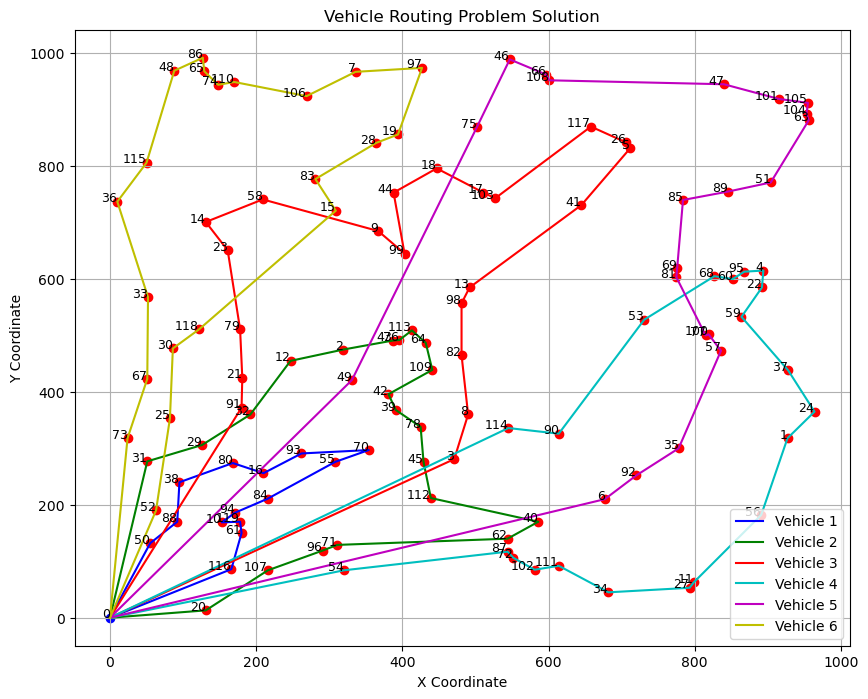

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10" =====================
Number of Nodes: 115
To minimize the total distance in the CVRP problem for the given dataset, we need a strategy that prioritizes proximity while also considering demand to avoid inefficient routes. Given the characteristics of the data (e.g., vehicle capacity = 169, max demand = 99, and a wide range of distances), here's the proposed strategy:

### Improvement Strategy:
1. **Demand Weight (a)**: A small positive value to slightly favor higher-demand nodes, ensuring vehicles are utilized efficiently without straying too far from the depot.  
2. **Distance Weight (b)**: A large negative value to heavily penalize distant nodes, forcing the algorithm to prioritize nearby nodes and cluster deliveries geographically.  
3. **Bias Term (c)**: A small positive constant to break ties when scores are otherwise equal.  

### Weight Values:  
**[0.1, -2.0, 0.

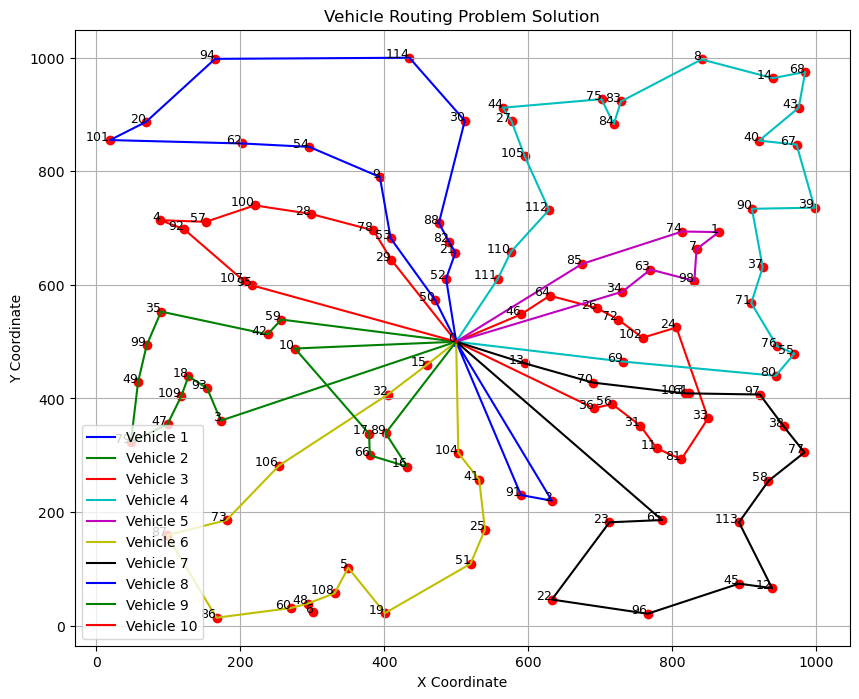

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10" =====================
Number of Nodes: 139
Given the goal of minimizing total distance and the data characteristics (vehicle capacity = 106, demand range = [0, 10], average distance = 503.47, max distance = 1252.12), here's a strategy that prioritizes distance reduction while accounting for demand and exploration:

**Improvement Strategy:**  
Since the primary objective is distance minimization, the distance weight (`b`) should dominate the scoring function. However, to avoid overly greedy behavior and ensure feasible load distribution, we include a small demand weight (`a`) and a tiny bias term (`c`) for exploration.  

Proposed weights:  
`[0.1, -1.5, 0.01]`  

**Rationale:**  
1. **Demand weight (`a = 0.1`):**  
   - Small positive value to slightly favor higher demands (helps consolidate routes without violating capacity).  
   - Since demands are small (max 10), th

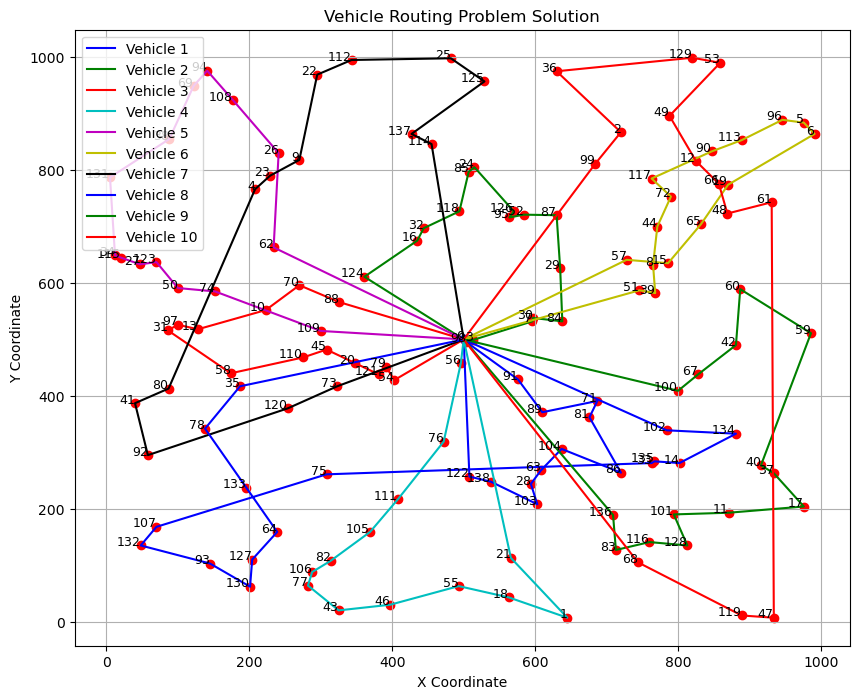

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),Min no of trucks: 13" =====================
Number of Nodes: 110
Given the goal of minimizing total distance and the dataset characteristics (vehicle capacity=66, demand range=[0,10], distance range=[0, 1278], avg distance=507), here's a strategy that prioritizes proximity while accounting for demand efficiency:

**Strategy Rationale**:  
1. **Demand weight (a)**: Set to a small positive value (0.1) to mildly favor higher-demand nodes, ensuring capacity utilization without sacrificing route compactness.  
2. **Distance weight (b)**: Strong negative weight (-1.0) to heavily prioritize nearby nodes, directly reducing route lengths.  
3. **Bias term (c)**: Neutral (0) to avoid skewing the selection artificially.  

**Weight Values**:  
```python
[0.1, -1.0, 0]
```

**Why This Works**:  
- The negative distance weight aggressively minimizes travel distance per step.  
- The small demand weight pr

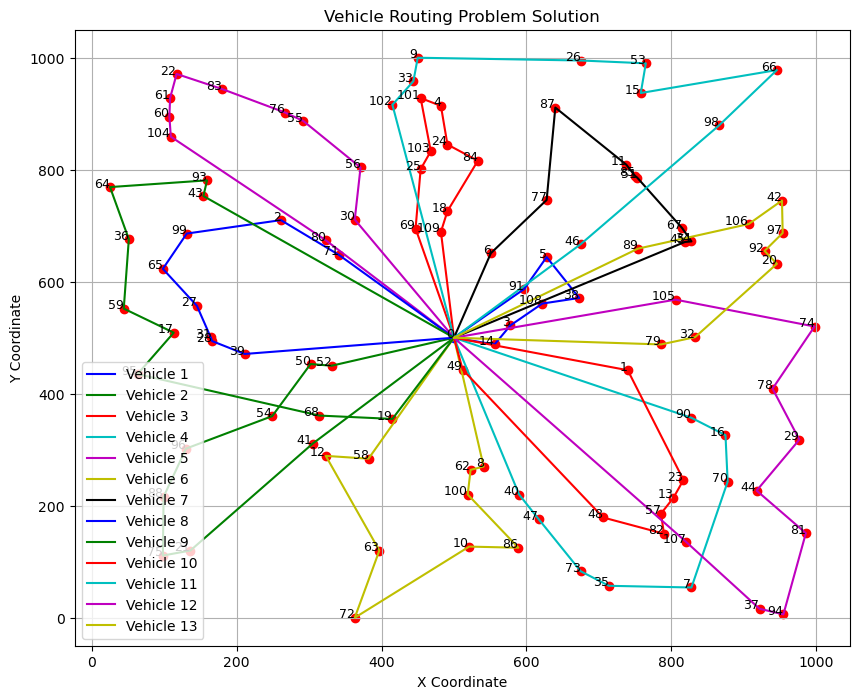

In [60]:
if __name__ == "__main__":
    root_folder = './data/large'
    cvrp_instances = read_all_instances(root_folder, ending='.vrp')

    global_best_cost = float('inf')
    global_best_routes = None
    global_best_strategy = None
    global_best_instance_name = None
    global_best_feasible = False 

    with open('results_large.txt', 'w') as f:
        for i in range(len(cvrp_instances)):
            cvrp_instance = cvrp_instances[i]
            vehicle_capacity = cvrp_instance['capacity']
            demands = cvrp_instance['demand']
            distance_matrix = [[value for value in row] for row in cvrp_instance['edge_weight']]
            node_coords = cvrp_instance['node_coord']
            instance_name = cvrp_instance['comment']
            f.write(f"===================== {instance_name} =====================\n")
            
            print("=====================", instance_name, "=====================")
            match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))
            if match:
                num_vehicles = int(match.group(1))
            else:
                match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))
                if match_min_no_of_trucks:
                    num_vehicles = int(match_min_no_of_trucks.group(1))
                else:
                    num_vehicles = None

            num_nodes = len(node_coords)
            data_detail_dict = {
                "instance_name": instance_name,
                "vehicle_capacity": vehicle_capacity,
                "demand_distribution": {
                    "min_demand": min(demands),
                    "max_demand": max(demands),
                },
                "distance_matrix_properties": {
                    "min_distance": min([min(row) for row in distance_matrix]) if distance_matrix else 0,
                    "max_distance": max([max(row) for row in distance_matrix]) if distance_matrix else 0,
                    "average_distance": sum([sum(row) for row in distance_matrix]) / (len(distance_matrix) * len(distance_matrix[0])) if distance_matrix else 0
                },
                "num_vehicles": num_vehicles,
                "num_nodes": num_nodes
            }
            print("Number of Nodes:", num_nodes)
           

    
            initial_routes, initial_cost, initial_feasible,best_routes, best_cost, best_feasible, best_strategy, all_strategy_results = funsearch(
                distance_matrix, demands, num_vehicles, vehicle_capacity, data_detail_dict
            )
            print("Initial routes:", initial_routes)  
            print("Initial total distance:", initial_cost)  
            print("Initial feasible:", initial_feasible)  
            f.write(f"Initial feasible: {initial_feasible}\n")  
            f.write(f"Initial routes: {initial_routes}\n")  
            f.write(f"Initial total distance: {initial_cost}\n")  
            print("Best routes found:", best_routes)
            print("Best total distance:", best_cost)
            print("Feasible (capacity constraint met):", best_feasible)  
            print("Best strategy:", best_strategy)
            
            f.write(f"Feasible: {best_feasible}\n") 
            f.write(f"Best routes found: {best_routes}\n")
            f.write(f"Best total distance: {best_cost}\n")
            f.write(f"Best strategy: {best_strategy}\n")
            test_capacity_constraint_print(best_routes, demands, vehicle_capacity)

            f.write("\nLLM Strategy Results:\n")
            for  strategy, cost ,feasible in all_strategy_results:
                f.write(f"Strategy: {strategy}, Cost: {cost},Feasible:{feasible}\n")

            if best_feasible:
                plot_CVRP_solution(best_routes, node_coords)